In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

import pickle
import numpy
from numpy import vstack
import math

from numpy.random import default_rng
%matplotlib inline 
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

rng = default_rng()
print(torch.cuda.get_device_name(0))

Mounted at /content/drive
Tesla K80


In [2]:
dir_path = "/content/drive/My Drive/Capstone"
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata = unpickle(dir_path + '/cifar-100-python/meta')
trainDataDict = unpickle(dir_path + '/cifar-100-python/train')
testDataDict = unpickle(dir_path + '/cifar-100-python/test')

In [3]:
print(len(metadata[b'fine_label_names']))
print(len(metadata[b'coarse_label_names']))
print(len(trainDataDict))
print(len(testDataDict))
print(trainDataDict.keys())
#len(trainData[b'fine_labels'])
len(trainDataDict[b'fine_labels'])

100
20
5
5
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


50000

In [4]:
def partitionClients(numClients, dataDict):
    classDist = [100000 for i in range(numClients)]
    # trainDataByClient is a list of lists. Each inner list contains all the indexes of images that belong to that client
    trainDataByClientIdxs = []
    # Initialize list of dicts
    for i in range(numClients):
        trainDataByClientIdxs.append([])

    for labelClass in range(100):
        clientDist = rng.dirichlet(classDist)
            
        dataIdx = 0
        for client in range(numClients):
            totalImgs = math.floor(clientDist[client]*(len(dataDict[b'fine_labels'])/100))
            if (totalImgs == 0):
                continue
            imgsSaved = 0

            while (dataIdx < len(dataDict[b'fine_labels'])):
                # Find images with label labelClass
                if (dataDict[b'fine_labels'][dataIdx] == labelClass):
                    trainDataByClientIdxs[client].append(dataIdx)
                    imgsSaved += 1
                dataIdx += 1
                if (imgsSaved == totalImgs):
                    break

            if (imgsSaved != totalImgs):
                print("class: ", labelClass, "ran out of images")
                
    return trainDataByClientIdxs


In [33]:
trainDataIdx = partitionClients(10, trainDataDict)
testDataIdx = partitionClients(10, testDataDict)

b'dinosaur'


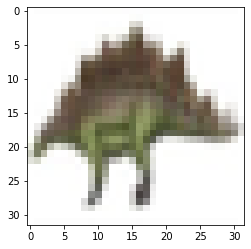

In [6]:
img = trainDataDict[b'data'][1].reshape(3,32,32)
print(metadata[b'fine_label_names'][trainDataDict[b'fine_labels'][1]])
img = numpy.moveaxis(img, 0, 2)
plt.imshow(img, interpolation='nearest')

In [7]:
class FEDCIFAR100Dataset(Dataset):
  def __init__(self, dataDict, clientIdxArr, transform):
    self.data = dataDict
    self.idxArr = clientIdxArr
    self.len = len(self.idxArr)
    self.transform = transform

  def __len__(self):
    return self.len
  
  def __getitem__(self, idx):
    dataIdx = self.idxArr[idx]
    image = self.data[b'data'][dataIdx]
    img_tensor = torch.from_numpy(image.reshape(3,32,32)).float()
    if self.transform:
      img_tensor = self.transform(img_tensor)
    label_id = torch.tensor(self.data[b'fine_labels'][dataIdx])
    return img_tensor, label_id

In [34]:
transform=transforms.Compose([transforms.Normalize((129.30428, 124.07023, 112.43411),(68.17024, 65.391785, 70.4184))])
clientNr = 9
trainData = FEDCIFAR100Dataset(trainDataDict, trainDataIdx[clientNr], transform=transform)
testData = FEDCIFAR100Dataset(testDataDict, testDataIdx[clientNr], transform=transform)
trainLoader = DataLoader(trainData, batch_size=256, shuffle=True)
testLoader = DataLoader(testData, batch_size=1024)
print(len(trainDataIdx[clientNr]))
print(len(testDataIdx[clientNr]))

4945
955


In [9]:
allTrainData = [i for i in range(50000)]
allTestData = [i for i in range(10000)]
allTrainData = FEDCIFAR100Dataset(trainDataDict, allTrainData, transform=transform)
allTestData = FEDCIFAR100Dataset(testDataDict, allTestData, transform=transform)
allTrainLoader = DataLoader(allTrainData, batch_size=256)
allTestLoader = DataLoader(allTestData, batch_size=1024)

In [10]:
imgs = [item[0] for item in allTrainData] # item[0] and item[1] are image and its label
imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

-1.6108942e-06 -4.064479e-06 -8.838749e-07
1.0000007 0.99999964 0.9999982


In [31]:
def train_model(trainLoader, testLoader, model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    # enumerate epochs
    for epoch in range(epochs):
        print('Epoch', epoch)
        model.train()
        # enumerate mini batches
        totalLoss = 0;
        totalPreds = 0;
        correctPreds = 0;
        for i, (inputs, targets) in enumerate(trainLoader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            outputs = model(inputs)
            _,predictions = torch.max(outputs, dim=1)
            correctPreds += torch.sum(predictions==targets).item()
            totalPreds += targets.size(0)
            # calculate loss
            loss = criterion(outputs, targets)
            totalLoss += loss;
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        acc = 100 * correctPreds/totalPreds
        train_acc_vec.append(acc)
        print('Train acc:', '{:.2f}%'.format(acc) )
        print('Train loss:', '{:.4f}'.format((totalLoss/len(trainLoader))))
        evaluate_model(testLoader, model, criterion)
        
# evaluate the model
def evaluate_model(testLoader, model, criterion):
    with torch.no_grad():
      model.eval()
      totalPreds = 0
      correctPreds = 0
      for i, (inputs, targets) in enumerate(testLoader):
          inputs = inputs.to(device)
          targets = targets.to(device)
          # evaluate the model on the test set
          outputs = model(inputs)
          #loss = criterion(outputs, targets)

          _,predictions = torch.max(outputs, dim=1)
          correctPreds += torch.sum(predictions==targets).item()
          totalPreds += targets.size(0)

      # calculate accuracy
      acc = 100 * correctPreds/totalPreds
      test_acc_vec.append(acc)
      print('Test accuracy:', "{:.2f}".format(acc), '%')

Epoch 0
Train acc: 1.05%
Train loss: 9.4989
Test accuracy: 0.94 %
Epoch 1
Train acc: 1.11%
Train loss: 10.7624
Test accuracy: 0.94 %
Epoch 2
Train acc: 0.97%
Train loss: 7.4244
Test accuracy: 0.52 %
Epoch 3
Train acc: 1.11%
Train loss: 5.0628
Test accuracy: 1.26 %
Epoch 4
Train acc: 1.17%
Train loss: 4.7374
Test accuracy: 1.47 %
Epoch 5
Train acc: 1.52%
Train loss: 4.7586
Test accuracy: 1.47 %
Epoch 6
Train acc: 1.48%
Train loss: 4.6597
Test accuracy: 1.47 %
Epoch 7
Train acc: 1.70%
Train loss: 4.6438
Test accuracy: 1.68 %
Epoch 8
Train acc: 1.84%
Train loss: 4.5854
Test accuracy: 1.99 %
Epoch 9
Train acc: 1.72%
Train loss: 4.5699
Test accuracy: 2.09 %
Epoch 10
Train acc: 1.78%
Train loss: 4.5210
Test accuracy: 3.14 %
Epoch 11
Train acc: 2.55%
Train loss: 4.4793
Test accuracy: 2.62 %
Epoch 12
Train acc: 2.43%
Train loss: 4.4599
Test accuracy: 2.51 %
Epoch 13
Train acc: 2.61%
Train loss: 4.4369
Test accuracy: 2.51 %
Epoch 14
Train acc: 2.87%
Train loss: 4.4048
Test accuracy: 2.93 %
Epoc

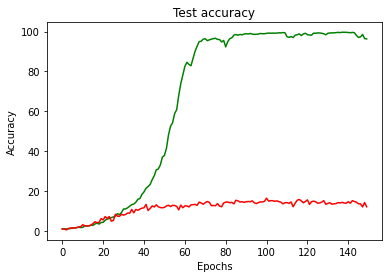

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
numpy.random.seed(0)
torch.manual_seed(0)

train_acc_vec = []
test_acc_vec = []

model = models.resnet50()
#for param in model.parameters():
#    param.requires_grad = False
ftrs = model.fc.in_features
model.fc = nn.Linear(ftrs, 100)
model = model.to(device)
train_model(trainLoader, testLoader, model, 150)

epochs = range(150)
plt.plot(epochs, train_acc_vec, 'g')
plt.plot(epochs, test_acc_vec, 'r')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()